In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import sklearn
import seaborn as sns
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model
#import scikits.statsmodels as sm

In [73]:
url = 'Non_Eruption_Analysis_Updated.csv'
non_erupting = pd.read_csv(url)
non_erupting = non_erupting.drop('Unnamed: 0', axis=1)
#non_erupting.replace('Na',np.nan, inplace=True)
non_erupting['Eruption'] = 0
non_erupting.head()
#non_erupting.keys()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,solar_region,active_region,Eruption
0,45,7.564764e+09,16168.805809,6.168439e+09,1.640895,820.900541,0.002343,0.285714,711.119135,1.851593,...,0.303481,-289.185742,617.737139,0.966848,1.283324e-06,0.283041,-0.430376,0,0,0
1,68,9.570003e+09,859.071410,6.163937e+09,1.119408,3217.543074,-0.001206,-0.250000,3393.403973,1.796474,...,0.837694,-512.194496,677.675873,1.174074,7.288285e-07,0.347411,0.350074,0,1,0
2,146,9.471339e+09,41986.899921,3.769297e+09,-0.849078,3268.798567,0.027267,0.400000,2051.688011,0.110602,...,-1.222649,242.954121,-508.451807,1.807644,1.761585e-06,0.257390,-0.478536,0,0,0
3,160,9.055176e+09,14375.335944,2.888129e+09,0.241333,866.382595,0.002529,-0.400000,430.713124,0.615826,...,0.188663,-591.248004,386.710205,1.841845,-1.521535e-06,0.323137,0.539716,0,1,0
4,197,9.291964e+09,10166.645689,2.303075e+09,-0.162335,1529.055734,-0.000229,0.500000,419.947129,0.119720,...,0.567651,-607.254323,476.535838,1.310398,1.025159e-06,0.211130,-0.089955,0,1,0


In [74]:
url = 'Eruption_Analysis_Updated.csv'
erupting = pd.read_csv(url)
erupting = erupting.drop('Unnamed: 0', axis=1)
#erupting.replace('Na',np.nan, inplace=True)
#erupting = erupting.astype(float)
erupting['Eruption'] = 1
erupting = erupting.dropna()
erupting.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,avg_decay_index,decay_index_slope,...,tilt_skew,avg_xcen,avg_ycen,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,solar_region,active_region,Eruption
0,15,1.097815e+10,-13370.431356,6.072829e+09,1.319385,2072.790662,-0.002303,0.200000,0.405716,3.566694e-07,...,-0.550865,-117.715778,510.907599,1.329568,2.345084e-08,0.640376,-0.278408,0,0,1
1,57,1.899906e+10,-18661.156780,6.805377e+09,-0.442429,5098.999213,-0.005713,0.142857,0.159955,-1.797584e-06,...,-1.106122,-59.687618,298.202714,0.529745,3.563938e-07,0.210505,2.400850,0,1,1
2,110,9.949694e+09,2989.447284,4.907138e+09,0.348667,1706.056265,0.001813,-0.200000,0.459279,-7.278316e-09,...,0.367832,35.969492,420.964402,1.485462,2.102280e-07,0.340379,0.109685,0,0,1
3,144,9.430330e+09,3529.134085,8.434491e+09,1.750261,2285.846427,-0.002171,0.142857,0.355680,-8.882530e-07,...,-0.155755,-182.206739,-236.898713,1.170807,1.659979e-06,0.433823,0.847777,0,0,1
4,171,5.605677e+09,-1197.610778,1.730809e+09,1.120567,873.097034,0.000115,-0.375000,0.580926,2.364704e-06,...,1.286171,150.999963,732.897369,0.867159,-2.677481e-07,0.353588,1.078732,0,1,1


In [75]:
print len(erupting)
print len(non_erupting)

126
141


# Running various K-S tests to see which parameters may be good to test

In [76]:
p_values = []
items = []
for item in erupting.keys():
    print item
    eruption = erupting[item].tolist()
    neruption = non_erupting[item].tolist()
    ksscore = stats.ks_2samp(eruption, neruption)
    items.append(item)
    p_values.append(ksscore[1])
    print item
    #p_values.append(ksscore[1])
print p_values
test = pd.Series(p_values, index=items)
test.head

Track No.
Track No.
avg_len
avg_len
len_slope
len_slope
len_stdev
len_stdev
len_skew
len_skew
avg_area
avg_area
area_slope
area_slope
avg_chirality
avg_chirality
avg_decay_index
avg_decay_index
decay_index_slope
decay_index_slope
area_stdev
area_stdev
area_skew
area_skew
chirality_slope
chirality_slope
avg_barbs
avg_barbs
barb_slope
barb_slope
barb_stdev
barb_stdev
barb_skew
barb_skew
avg_tilt
avg_tilt
tilt_slope
tilt_slope
tilt_stdev
tilt_stdev
tilt_skew
tilt_skew
avg_xcen
avg_xcen
avg_ycen
avg_ycen
avg_L_to_W
avg_L_to_W
L_to_W_slope
L_to_W_slope
L_to_W_stdev
L_to_W_stdev
L_to_W_skew
L_to_W_skew
solar_region
solar_region
active_region
active_region
Eruption
Eruption
[0.00059688638214778957, 0.88670684537411926, 1.2136693831879597e-06, 0.57271769676454787, 0.00071424417734453549, 0.85216118321978818, 0.00075514249216115383, 0.30991374344225364, 0.75947223717977497, 0.066905791313473545, 0.55887632794893327, 0.1442055445433516, 0.38288897783175879, 0.51358525720556014, 0.002548523776289

<bound method Series.head of Track No.            5.968864e-04
avg_len              8.867068e-01
len_slope            1.213669e-06
len_stdev            5.727177e-01
len_skew             7.142442e-04
avg_area             8.521612e-01
area_slope           7.551425e-04
avg_chirality        3.099137e-01
avg_decay_index      7.594722e-01
decay_index_slope    6.690579e-02
area_stdev           5.588763e-01
area_skew            1.442055e-01
chirality_slope      3.828890e-01
avg_barbs            5.135853e-01
barb_slope           2.548524e-03
barb_stdev           4.343063e-01
barb_skew            8.344727e-01
avg_tilt             5.704039e-01
tilt_slope           7.684441e-01
tilt_stdev           9.015836e-01
tilt_skew            7.344179e-01
avg_xcen             2.410920e-12
avg_ycen             5.739902e-03
avg_L_to_W           2.984785e-01
L_to_W_slope         7.840619e-03
L_to_W_stdev         1.425997e-02
L_to_W_skew          9.183400e-01
solar_region         1.000000e+00
active_region      

In [77]:
#KS test for filament length
erupt_len = erupting['avg_len'].tolist()
nerupt_len = non_erupting['avg_len'].tolist()
stats.ks_2samp(erupt_len, nerupt_len)

Ks_2sampResult(statistic=0.070246538331644626, pvalue=0.88670684537411926)

In [78]:
#KS test for change in length (slope)
erupt_slen = erupting['len_slope'].tolist()
nerupt_slen = non_erupting['len_slope'].tolist()
stats.ks_2samp(erupt_slen, nerupt_slen)

Ks_2sampResult(statistic=0.32269503546099298, pvalue=1.2136693831879597e-06)

In [79]:
stats.anderson_ksamp([erupt_slen, nerupt_slen])

Anderson_ksampResult(statistic=15.362887940613678, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=1.563300442225998e-05)

In [80]:
erupt_area = erupting['avg_area'].tolist()
nerupt_area = non_erupting['avg_area'].tolist()
stats.ks_2samp(erupt_area, nerupt_area)

Ks_2sampResult(statistic=0.073454913880445782, pvalue=0.85216118321978818)

In [81]:
stats.anderson_ksamp([erupt_area, nerupt_area])

Anderson_ksampResult(statistic=-0.57821274000136202, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.6406700454565993)

In [82]:
#KS test for change in area (slope)
erupt_sarea = erupting['area_slope'].astype(float).tolist()
nerupt_sarea = non_erupting['area_slope'].astype(float).tolist()
stats.ks_2samp(erupt_sarea, nerupt_sarea)

Ks_2sampResult(statistic=0.23944613306315438, pvalue=0.00075514249216115383)

In [83]:
stats.anderson_ksamp([erupt_sarea, nerupt_sarea])

Anderson_ksampResult(statistic=8.1613290254419528, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.00038584273172020565)

In [84]:
erupt_chiral = erupting['avg_chirality'].tolist()
nerupt_chiral = non_erupting['avg_chirality'].tolist()
stats.ks_2samp(erupt_chiral, nerupt_chiral)

Ks_2sampResult(statistic=0.11634582911178659, pvalue=0.30991374344225364)

In [85]:
stats.anderson_ksamp([erupt_chiral, nerupt_chiral])

Anderson_ksampResult(statistic=0.88278446083575113, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.14173786175185882)

In [86]:
erupt_schiral = erupting['chirality_slope'].astype(float).tolist()
nerupt_schiral = non_erupting['chirality_slope'].astype(float).tolist()
stats.ks_2samp(erupt_schiral, nerupt_schiral)

Ks_2sampResult(statistic=0.10942249240121571, pvalue=0.38288897783175879)

In [87]:
stats.anderson_ksamp([erupt_schiral, nerupt_schiral])

Anderson_ksampResult(statistic=0.37538275833859391, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.23642985338683342)

In [88]:
erupt_tilt = erupting['avg_tilt'].tolist()
nerupt_tilt = non_erupting['avg_tilt'].tolist()
stats.ks_2samp(erupt_tilt, nerupt_tilt)

Ks_2sampResult(statistic=0.094562647754137114, pvalue=0.57040389062845709)

In [89]:
stats.anderson_ksamp([erupt_tilt, nerupt_tilt])

Anderson_ksampResult(statistic=-0.30194033900948697, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.47769547028015125)

In [90]:
erupt_stilt = erupting['tilt_slope'].dropna().astype(float).tolist()
nerupt_stilt = non_erupting['tilt_slope'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_stilt, nerupt_stilt)

Ks_2sampResult(statistic=0.080209388720027031, pvalue=0.76844414007264339)

In [91]:
stats.anderson_ksamp([erupt_stilt, nerupt_stilt])

Anderson_ksampResult(statistic=-0.53100455596027996, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.6091606644626943)

In [92]:
erupt_avg_decay = erupting['avg_decay_index'].dropna().astype(float).tolist()
nerupt_avg_decay = non_erupting['avg_decay_index'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_avg_decay, nerupt_avg_decay)

Ks_2sampResult(statistic=0.080884836203985122, pvalue=0.75947223717977497)

In [93]:
stats.anderson_ksamp([erupt_avg_decay, nerupt_avg_decay])

Anderson_ksampResult(statistic=-0.77533545115191371, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.7918081800690223)

In [94]:
erupt_sdecay = erupting['decay_index_slope'].dropna().astype(float).tolist()
nerupt_sdecay = non_erupting['decay_index_slope'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_sdecay, nerupt_sdecay)

Ks_2sampResult(statistic=0.15721040189125296, pvalue=0.066905791313473545)

In [95]:
stats.anderson_ksamp([erupt_sdecay, nerupt_sdecay])

Anderson_ksampResult(statistic=0.34069009340384682, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.24496416635409182)

In [96]:
erupt_solar_region= erupting['solar_region'].dropna().astype(float).tolist()
nerupt_solar_region = non_erupting['solar_region'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_solar_region, nerupt_solar_region)

Ks_2sampResult(statistic=0.018405943937858771, pvalue=1.0000000000000002)

In [97]:
stats.anderson_ksamp([erupt_solar_region, nerupt_solar_region])

Anderson_ksampResult(statistic=-0.30070177892303784, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.4770713949439487)

In [98]:
erupt_y= erupting['avg_ycen'].dropna().astype(float).tolist()
nerupt_y = non_erupting['avg_ycen'].dropna().astype(float).tolist()
stats.ks_2samp(erupt_y, nerupt_y)

Ks_2sampResult(statistic=0.20634920634920634, pvalue=0.0057399020972154404)

In [99]:
stats.anderson_ksamp([erupt_y, nerupt_y])

Anderson_ksampResult(statistic=3.3749761362718238, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.013872513784382)

# Preparing for random forest classifier by putting erupting/nonerupting data together

In [100]:
##Now lets see if we can predict whether a filament will erupt or not. 
#erupting = erupting.astype(float)
all_eruptions=erupting.append(non_erupting)#,ignore_index = True)   #adding everything together
#all_eruptions = all_eruptions.dropna() #for now, dropping everything with NaN
all_eruptions.head()

,Eruption,L_to_W_skew,L_to_W_slope,L_to_W_stdev,Track No.,active_region,area_skew,area_slope,area_stdev,avg_L_to_W,...,barb_stdev,chirality_slope,decay_index_slope,len_skew,len_slope,len_stdev,solar_region,tilt_skew,tilt_slope,tilt_stdev
0,1,-0.278408,2.345084e-08,0.640376,15,0,0.267216,-0.002303,1248.783467,1.329568,...,1.496663,3.558873e-06,3.566694e-07,1.319385,-13370.431356,6.072829e+09,0,-0.550865,0.000093,28.194303
1,1,2.400850,3.563938e-07,0.210505,57,1,0.049522,-0.005713,2077.915766,0.529745,...,2.938138,2.394560e-06,-1.797584e-06,-0.442429,-18661.156780,6.805377e+09,0,-1.106122,-0.000103,67.416151
2,1,0.109685,2.102280e-07,0.340379,110,0,0.479399,0.001813,1079.377133,1.485462,...,1.707500,-7.741171e-07,-7.278316e-09,0.348667,2989.447284,4.907138e+09,0,0.367832,0.000005,13.437749
3,1,0.847777,1.659979e-06,0.433823,144,0,1.446848,-0.002171,2423.039674,1.170807,...,1.840586,-7.970894e-07,-8.882530e-07,1.750261,3529.134085,8.434491e+09,0,-0.155755,-0.000061,49.303897
4,1,1.078732,-2.677481e-07,0.353588,171,1,1.613887,0.000115,319.604775,0.867159,...,1.198958,5.221194e-07,2.364704e-06,1.120567,-1197.610778,1.730809e+09,0,1.286171,-0.000037,32.379508


In [101]:
#print all_eruptions['solar_region']

In [102]:
all_eruptions['L_to_W_stdev'].describe()

count    267.000000
mean       0.330547
std        0.211608
min        0.046171
25%        0.174296
50%        0.285519
75%        0.446801
max        1.276675
Name: L_to_W_stdev, dtype: float64

In [103]:
#The random forest does a better job with values near 0 in general
#So here I am going to scale all of the values so they get closer to 0
all_eruptions['avg_len'] = all_eruptions['avg_len']/1e9
all_eruptions['len_slope'] = all_eruptions['len_slope']/1e3
all_eruptions['len_stdev'] = all_eruptions['len_stdev']/1e8
all_eruptions['avg_area'] = all_eruptions['avg_area']/100
all_eruptions['area_slope'] = all_eruptions['area_slope']*100
all_eruptions['area_stdev'] = all_eruptions['area_stdev']/100
all_eruptions['avg_chirality'] = all_eruptions['avg_chirality']*10
all_eruptions['chirality_slope'] = all_eruptions['chirality_slope']*1e6
all_eruptions['barb_slope'] = all_eruptions['barb_slope']*1e6
all_eruptions['tilt_slope'] = all_eruptions['tilt_slope']*1e4
all_eruptions['L_to_W_slope'] = all_eruptions['L_to_W_slope']*1e6
all_eruptions['decay_index_slope'] = all_eruptions['decay_index_slope']*1e7
print all_eruptions['decay_index_slope']
all_eruptions.head()

0       3.566694
1     -17.975838
2      -0.072783
3      -8.882530
4      23.647040
5     -10.551633
6      -1.241301
7      17.541053
8       1.278209
9       6.548944
10      1.706167
11     82.910373
12     -0.581181
13      3.367587
14    -23.042678
15    -47.584562
16     18.419570
17    -10.681636
18    -21.113294
19      0.524904
20     34.274314
21      0.973055
22     -0.971903
23    -10.494385
24    -15.576739
25      9.655681
26    -25.605632
27     -1.887163
28    -17.010560
29      2.924929
         ...    
111   -16.955143
112    -8.338361
113    17.229483
114   -18.659679
115    64.430530
116     1.234466
117    -4.672339
118     3.307640
119   -38.520872
120    -3.891618
121    10.254690
122     0.447904
123    12.852360
124    -1.437210
125    16.212885
126    -0.909503
127    22.669873
128   -18.548521
129     3.933880
130    12.984966
131    12.805732
132     0.191682
133    -6.072884
134    21.334963
135    -3.634484
136    -1.707452
137     3.134277
138   -19.4325

,Eruption,L_to_W_skew,L_to_W_slope,L_to_W_stdev,Track No.,active_region,area_skew,area_slope,area_stdev,avg_L_to_W,...,barb_stdev,chirality_slope,decay_index_slope,len_skew,len_slope,len_stdev,solar_region,tilt_skew,tilt_slope,tilt_stdev
0,1,-0.278408,0.023451,0.640376,15,0,0.267216,-0.230258,12.487835,1.329568,...,1.496663,3.558873,3.566694,1.319385,-13.370431,60.728290,0,-0.550865,0.933202,28.194303
1,1,2.400850,0.356394,0.210505,57,1,0.049522,-0.571339,20.779158,0.529745,...,2.938138,2.394560,-17.975838,-0.442429,-18.661157,68.053775,0,-1.106122,-1.032049,67.416151
2,1,0.109685,0.210228,0.340379,110,0,0.479399,0.181333,10.793771,1.485462,...,1.707500,-0.774117,-0.072783,0.348667,2.989447,49.071378,0,0.367832,0.052598,13.437749
3,1,0.847777,1.659979,0.433823,144,0,1.446848,-0.217074,24.230397,1.170807,...,1.840586,-0.797089,-8.882530,1.750261,3.529134,84.344907,0,-0.155755,-0.605549,49.303897
4,1,1.078732,-0.267748,0.353588,171,1,1.613887,0.011485,3.196048,0.867159,...,1.198958,0.522119,23.647040,1.120567,-1.197611,17.308085,0,1.286171,-0.368781,32.379508


In [104]:
#Pull out the feature we want to predict (1 for eruption, 0 for no eruption)
Y = np.array(all_eruptions['Eruption'])  #getting the eruption status (variable that is trying to be predicted)

In [105]:
all_eruptions.to_csv('All_Eruption_Analysis_Updated.csv', columns = ('Track No.', 'avg_len', 'len_slope', 'avg_area', 'area_slope', 'avg_chirality', 'chirality_slope', 'avg_decay_index', 'decay_index_slope','avg_barbs', 'barb_slope','avg_tilt', 'tilt_slope','avg_xcen','avg_ycen','avg_L_to_W','L_to_W_slope', 'solar_region', 'active_region'))

In [106]:
#Now we need to remove that from our dataset. 
all_eruptions = all_eruptions.drop('Eruption',1)  #now dropping the eruption column! 

In [107]:
#Now we need to save all of the features as a matrix for the calucations later
X = all_eruptions.as_matrix()
print X

[[ -2.78408256e-01   2.34508393e-02   6.40375785e-01 ...,  -5.50864737e-01
    9.33202223e-01   2.81943027e+01]
 [  2.40084989e+00   3.56393845e-01   2.10505466e-01 ...,  -1.10612171e+00
   -1.03204858e+00   6.74161515e+01]
 [  1.09684559e-01   2.10227979e-01   3.40378714e-01 ...,   3.67831657e-01
    5.25980713e-02   1.34377489e+01]
 ..., 
 [  1.19077595e-01   1.60833678e+00   1.68506917e-01 ...,   3.23204847e-01
   -1.05462605e+00   1.08435120e+01]
 [ -1.76083431e-01  -1.93124555e-02   9.64696995e-02 ...,  -4.03902233e-01
    5.71139468e+00   7.88883296e+01]
 [  1.20072252e+00   6.86884157e-01   1.31532719e-01 ...,   4.54366220e-02
    1.50228269e-01   1.11844954e+01]]


Our goal is to be able to predict the outcome (Y) by using the features (X)
Since we have a binary outcome, we want to use a classification scheme
Because of this, I am going to try to use a random forest classifier (I can send you details on what this is)
This is a good method when there is only a small sample (200 events is very small in data science)



In [108]:
## your code here
non_erupt = 0.
for eruption in Y:
    if eruption == 0:
        non_erupt = non_erupt+1.
avg = non_erupt/len(Y)
print avg
print '%d percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close' % (avg*100)

0.52808988764
52 percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close


In [109]:
#Let's start by making 40 different 'forests' (based on decision trees)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
n_trees = range(1,41)
scores_range = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    #n_estimators - the number of trees in the forest
    #max_depth - how many branches on the tree. I added this keyword per Rafal's suggestion. We can play around with different depths (which I did more of later in the notebook).
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5)
    val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    #val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,10, shuffle=True)) #Try out a new type of scoring
    scores_range.append(val_score) 

0.690570563696


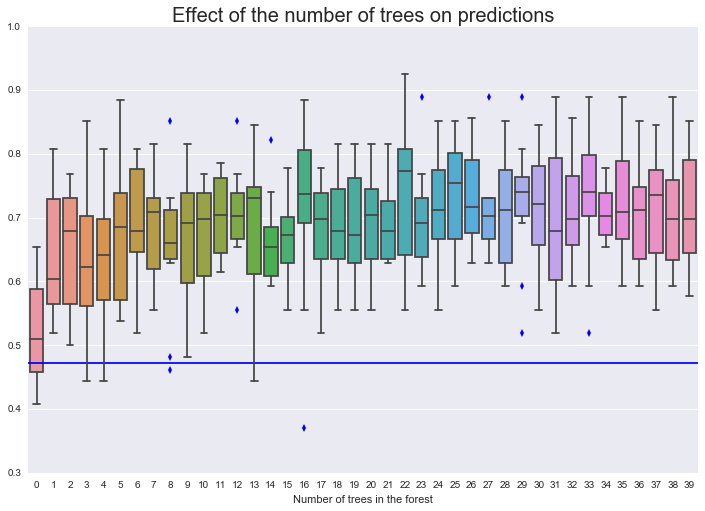

In [110]:
#How good at prediction is my tree? (I ran 40 different tests, so each bar is one test).
print np.mean(scores_range)
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Effect of the number of trees on predictions', fontsize=20)
plt.xlabel('Number of trees in the forest')
plt.axhline(y=1-avg)
sns.boxplot(data=scores_range)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/forests_with_1_to_40_trees.png')
#sns.boxplot(scores) #NOTE: Use this line if you have the older version of seaborn!!
#plt.savefig("/home/nschanch/Downloads/test_img.png")
#Note: This is before correcting for the unbalanced sample size. 

In [111]:
print val_score
print forest

[ 0.82142857  0.62962963  0.7037037   0.62962963  0.85185185  0.74074074
  0.69230769  0.69230769  0.57692308  0.80769231]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [112]:

#Let's start by making 40 different 'trees' (based on decisions)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

#Unlike above, now we want to make 40 different forests, each conaining the same number of trees (25)
n_trees = [25]*40
scores = []
#This will make 40 forests, and each forest will be made up of 1-40 trees successively
#This way, we can see how much of an effect adding more trees has on the predictions.
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5)
    val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,10, shuffle=True))
    #val_score = cross_val_score(forest, X=X, y=Y, cv=10)
    scores.append(val_score) 

0.716594424094


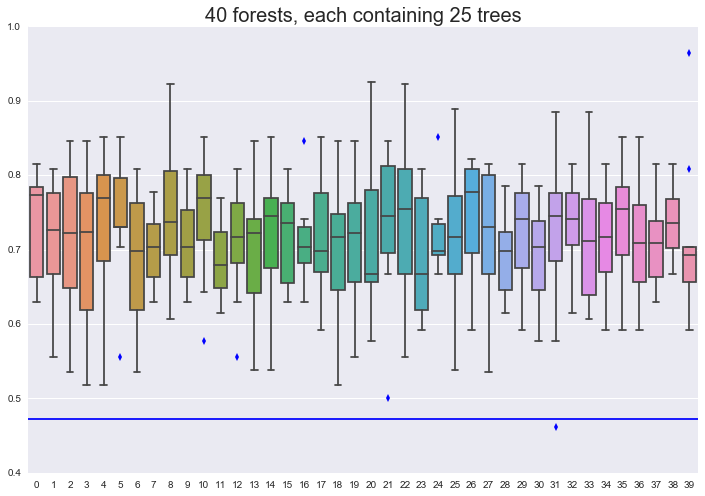

In [113]:
#How good at prediction is my tree? (I ran 40 different test, so each bar is one test).
print np.mean(scores)
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.title('40 forests, each containing 25 trees', fontsize=20)
sns.boxplot(data=scores)
plt.axhline(y=1-avg)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/forests_with_25_trees.png')
#sns.boxplot(scores)
#Note: This is before correcting for the unbalanced sample size. 

In [114]:
#print np.mean(scores)
#plt.figure(figsize=(12,8))
#plt.axhline(y=1-avg)
#plt.title('Effect of the number of trees on predictions compared to guessing the eruption class', fontsize=15)
#plt.xlabel('Number of Trees', fontsize=15)
#plt.ylabel('Prediction Accuracy', fontsize=15)
#sns.boxplot(data=scores)
#sns.boxplot(scores)
#plt.savefig('/home/nschanch/Desktop/random_forest_20_trees.png')

In [115]:
scores_2 = []
n_trees = [25]*40
for i in n_trees:
    forest_2 = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5)
    #Same thing, but using a different type of scoring (f1)
    #The F1 score is defined as the harmonic mean of recall and precision
    #So this tries to balance how well it does at picking out all of the erupting filaments and how many erupting filaments it is correct about
    val_score_2 = cross_val_score(forest_2, X=X, y=Y, cv=StratifiedKFold(Y,10, shuffle=True), scoring='f1')
    scores_2.append(val_score_2) 

0.675012270271


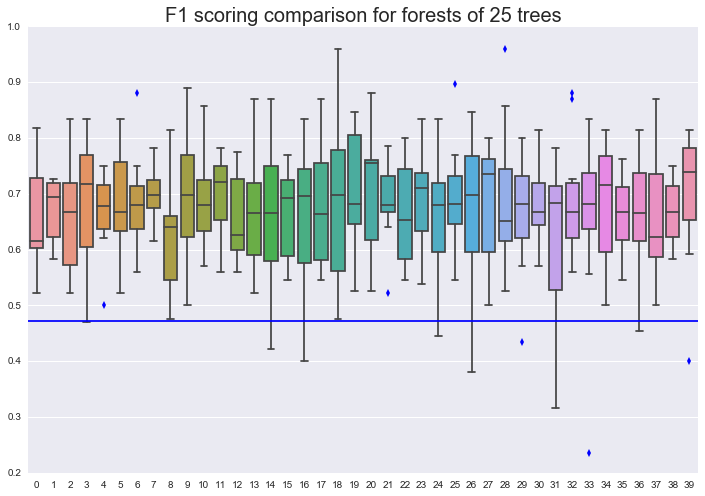

In [116]:
print np.mean(scores_2)
plt.figure(figsize=(12,8))
plt.title('F1 scoring comparison for forests of 25 trees',fontsize=20)
sns.boxplot(data=scores_2)
#sns.boxplot(scores_2)
plt.axhline(y=1-avg)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/f1_scoring_25_trees.png')

I don't really see a big difference between the two types of scoring...

In [117]:
#make the forest classifier and do that fit. Then find the probabilities
forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25)
fitted_forest = forest.fit(X, Y)
proba = fitted_forest.predict_proba(X)

#Make a prediction based on probabilities
class_predict = fitted_forest.predict(X)
print class_predict[:10]


#Now just make a prediction based on raw values of the probabilities
erupt_good = proba[:, 1]
sanity_predict = [0]*len(erupt_good)
print erupt_good[:10]
for i in range(len(sanity_predict)):
    if erupt_good[i] > 0.5:
        sanity_predict[i] = 1
    else:
        sanity_predict[i] = 0
        
        
print sanity_predict[:10]
#val_score = cross_val_score(forest, X=X, y=Y, cv=10)
#scores.append(val_score) 

(class_predict == sanity_predict).all()

[1 1 1 1 1 1 1 1 1 1]
[ 1.    0.68  0.96  0.8   0.88  0.84  0.76  0.84  0.72  0.96]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


True

In [118]:
from sklearn.cross_validation import StratifiedKFold, KFold
#Which features are leading to the good predictions?
feature_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#by_feature = feature_forest.feature_importances_
fitted_forest4a = feature_forest.fit(X, Y)
val_score_ = cross_val_score(fitted_forest4a, X=X, y=Y, cv=10)

val_score2_ = cross_val_score(fitted_forest4a, X=X,y=Y, cv=StratifiedKFold(Y,10))
imp_features = fitted_forest4a.feature_importances_
print val_score_
print val_score2_
print all_eruptions.keys()
print imp_features

[ 0.82142857  0.62962963  0.59259259  0.62962963  0.74074074  0.66666667
  0.65384615  0.69230769  0.76923077  0.84615385]
[ 0.78571429  0.55555556  0.51851852  0.7037037   0.77777778  0.77777778
  0.80769231  0.76923077  0.76923077  0.53846154]
Index([u'L_to_W_skew', u'L_to_W_slope', u'L_to_W_stdev', u'Track No.',
       u'active_region', u'area_skew', u'area_slope', u'area_stdev',
       u'avg_L_to_W', u'avg_area', u'avg_barbs', u'avg_chirality',
       u'avg_decay_index', u'avg_len', u'avg_tilt', u'avg_xcen', u'avg_ycen',
       u'barb_skew', u'barb_slope', u'barb_stdev', u'chirality_slope',
       u'decay_index_slope', u'len_skew', u'len_slope', u'len_stdev',
       u'solar_region', u'tilt_skew', u'tilt_slope', u'tilt_stdev'],
      dtype='object')
[ 0.02947265  0.03414468  0.03055396  0.06994299  0.0046021   0.02696345
  0.03662375  0.01340328  0.03429557  0.02064395  0.01993258  0.02415772
  0.01762644  0.01355141  0.03314857  0.20174215  0.05427004  0.02421047
  0.04227781  0.01

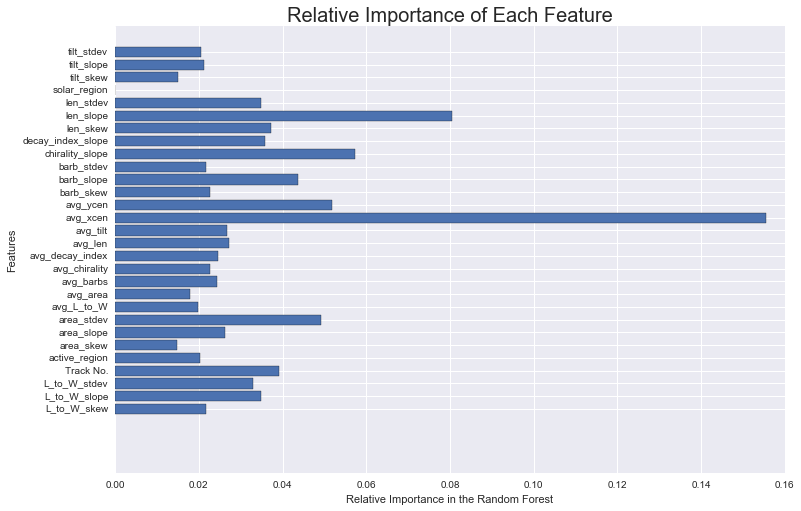

In [119]:
#Whitch features are most useful for prediction?
plt.figure(figsize=(12,8))
clf = RandomForestClassifier(n_estimators=15)

clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = all_eruptions.columns
#print len(importance_list)
#print len(name_list)
#importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature',fontsize=20)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importance.png')
plt.show()
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importance.png')

In [120]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired)
    plt.show()

In [121]:
#Look at the predictions.
#eruptions_subset = all_eruptions[['tilt_slp','area_slp']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

In [122]:
#eruptions_subset = all_eruptions[['fi_tilt_avg','fi_area_avg']].as_matrix()


#subset_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 15)
#fitted_subset = subset_forest.fit(eruptions_subset, Y)
#subset_val_score = cross_val_score(subset_forest, X=wine_subset, y=Y, cv=10)
#plt.title('Random Forest Decision Tree Surface')
#plot_decision_surface(fitted_subset, eruptions_subset, Y)

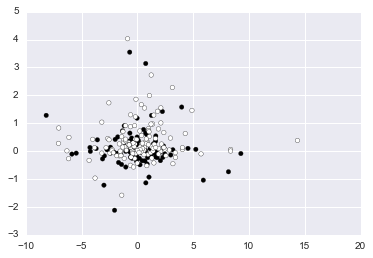

In [123]:
colors = Y
plt.scatter(all_eruptions['tilt_slope'],all_eruptions['area_slope'], c=colors)

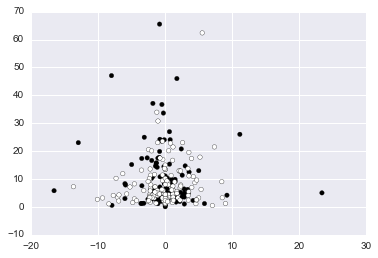

In [124]:
plt.scatter(all_eruptions['chirality_slope'],all_eruptions['area_stdev'], c=colors)

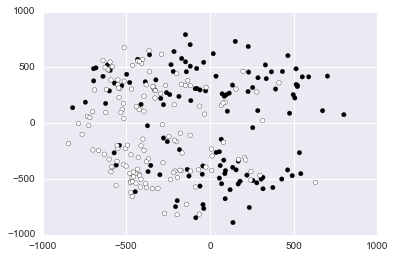

In [125]:
colors = Y
plt.scatter(all_eruptions['avg_xcen'],all_eruptions['avg_ycen'], c=colors)

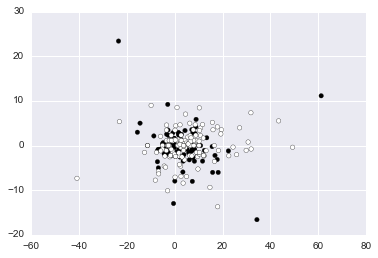

In [126]:
colors = Y
plt.scatter(all_eruptions['barb_slope'],all_eruptions['chirality_slope'], c=colors)

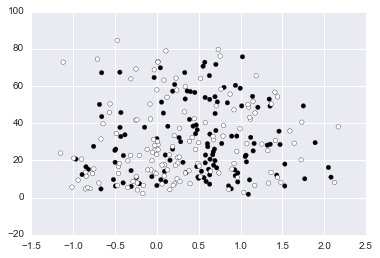

In [127]:
colors = Y
plt.scatter(all_eruptions['len_skew'],all_eruptions['tilt_stdev'], c=colors)

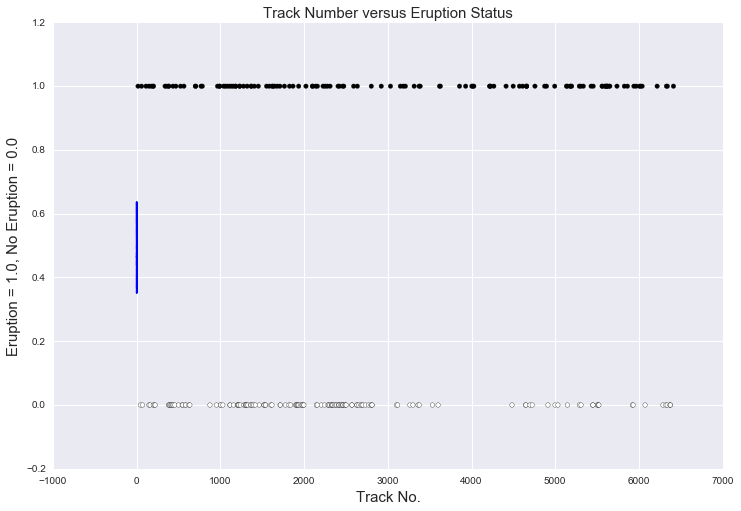

In [128]:
area_slp_X=all_eruptions['area_slope']
clf = linear_model.LinearRegression()
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(all_eruptions['Track No.'], Y, c=colors)
plt.title('Track Number versus Eruption Status', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.xlabel('Track No.', fontsize = 15)
clf.fit(all_eruptions['Track No.'][:,np.newaxis],Y)
plt.plot(area_slp_X, clf.predict(all_eruptions['Track No.'][:,np.newaxis]), color='blue')

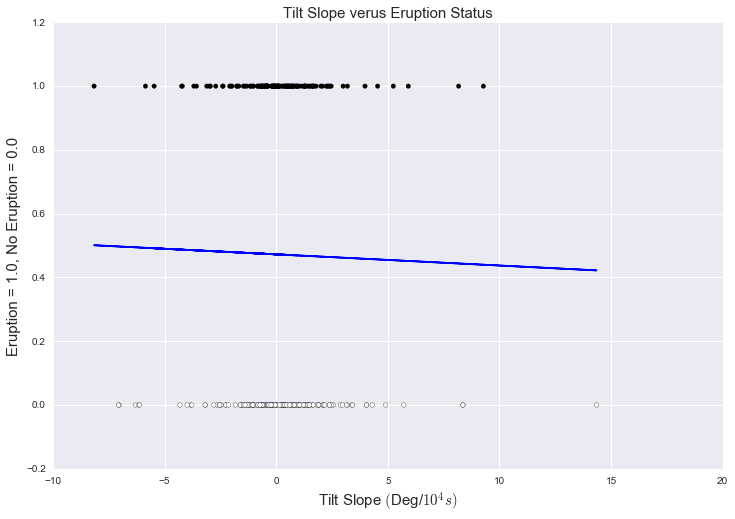

In [129]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
clf = linear_model.LinearRegression()
tilt_slp_X = np.array(all_eruptions['tilt_slope'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(tilt_slp_X, Y, c=colors)
#clf = Ridge(alpha=1.0)
#clf = linear_model.LogisticRegression(C=1e3)
clf = linear_model.LinearRegression()
clf.fit(tilt_slp_X[:,np.newaxis],Y)
plt.clf()
plt.scatter(tilt_slp_X, Y, c=colors)
plt.plot(tilt_slp_X, clf.predict(tilt_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Tilt Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Tilt Slope $($Deg/$10^4s)$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.figure(figsize=(12,8))
Y_predict = clf.predict(tilt_slp_X[:,np.newaxis])
#fig.gca().set_xlabel(r'wavelength $5000 \AA$')

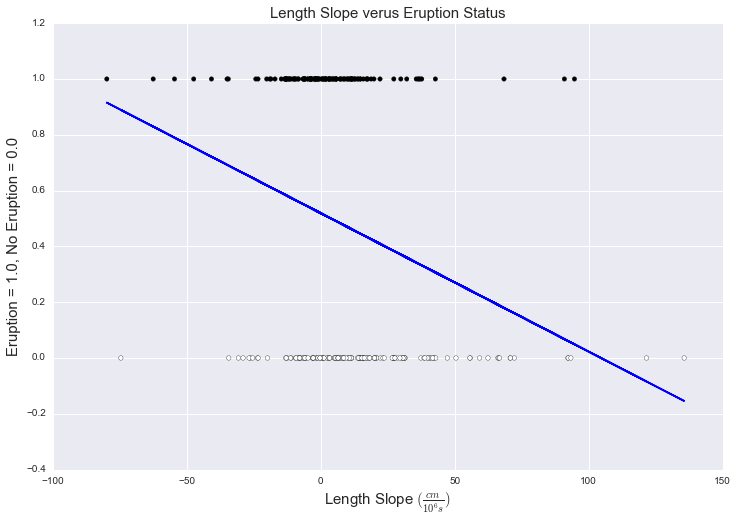

In [130]:
clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['len_slope'])
plt.figure(figsize=(12,8))
colors = Y
plt.scatter(length_slp_X, Y, c=Y)
clf.fit(length_slp_X[:,np.newaxis],Y)
plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length Slope verus Eruption Status', fontsize = 15)
plt.xlabel(r'Length Slope $(\frac{cm}{10^6s})$', fontsize = 15)
plt.ylabel('Eruption = 1.0, No Eruption = 0.0', fontsize = 15)
plt.grid(True)
plt.show()

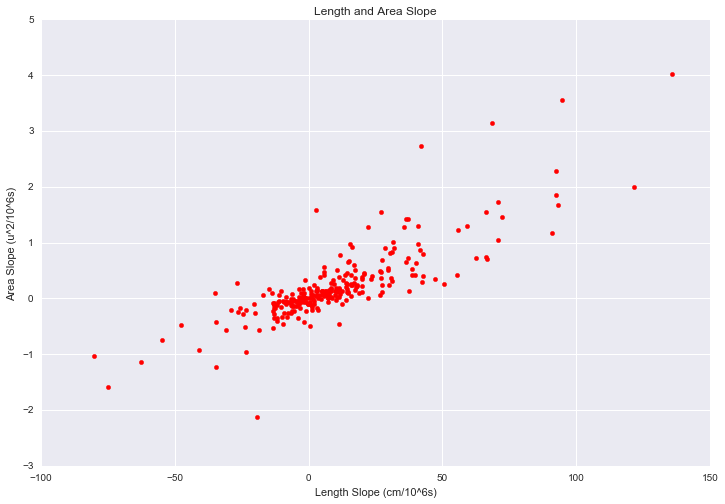

In [131]:
#clf = linear_model.LinearRegression()
length_slp_X = np.array(all_eruptions['len_slope'])
area_slp_X = np.array(all_eruptions['area_slope'])
plt.figure(figsize=(12,8))
plt.scatter(length_slp_X, area_slp_X, color='red')
#clf.fit(length_slp_X[:,np.newaxis],Y)
#plt.plot(length_slp_X, clf.predict(length_slp_X[:,np.newaxis]), color='blue')
#plt.xlim(0,.05)
#print Y
#print all_eruptions['area_slp']
plt.title('Length and Area Slope')
plt.xlabel('Length Slope (cm/10^6s)')
plt.ylabel('Area Slope (u^2/10^6s)')
plt.grid(True)
plt.show()

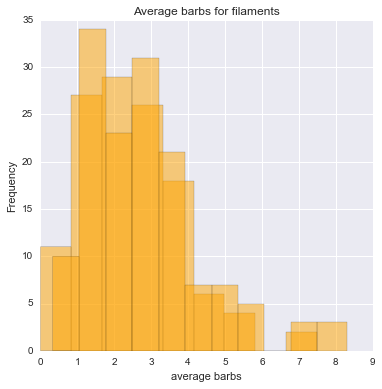

In [132]:
colors=Y
plt.xlabel('average barbs')
plt.ylabel('Number of Instances')
#plt.xlim([-3,3])
plt.title('Average barbs for filaments')
fig1 = plt.gcf()
fig1.set_size_inches(5.5,5.5)
plt.tight_layout()
erupting['avg_barbs'].plot(kind='hist',rwidth=1.5,  alpha=0.5,color='orange')
non_erupting['avg_barbs'].plot(kind='hist',rwidth=1.5, alpha=0.5, color='orange')
plt.show()
#all_eruptions['avg_barbs'].plot(kind=hist, c=colors)

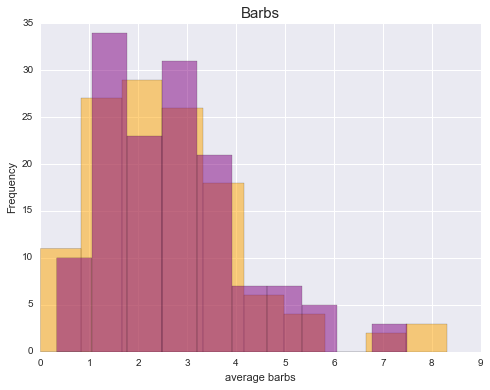

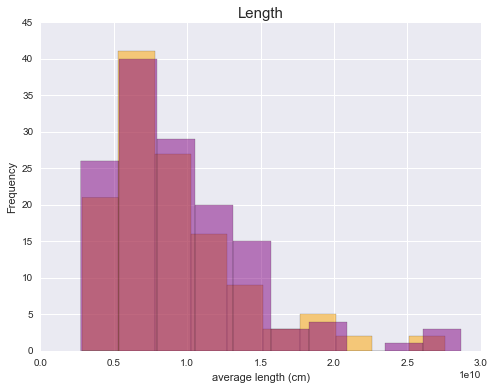

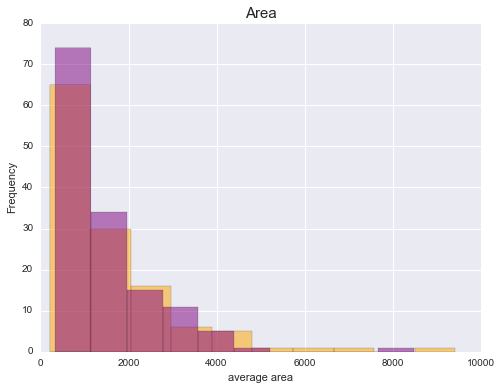

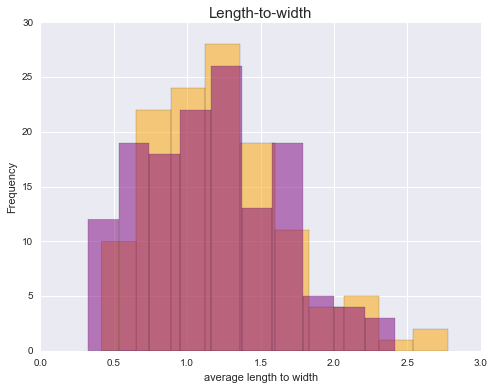

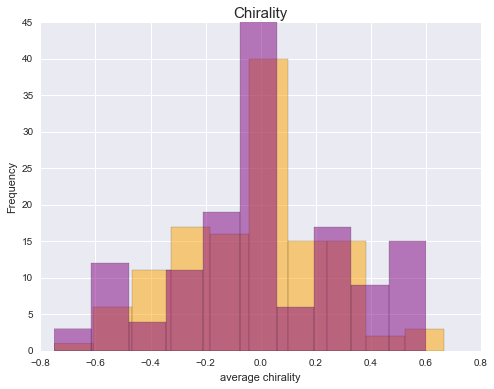

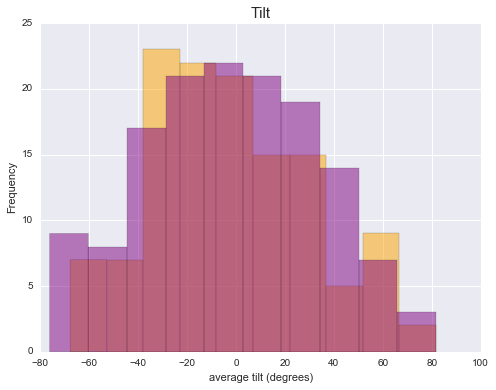

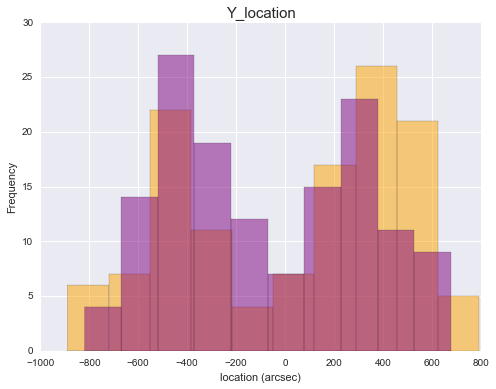

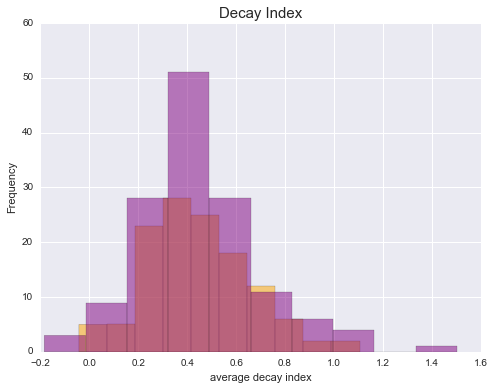

In [133]:
def comparison_plots(parameter, title, xlabel):
    colors=Y
    plt.xlabel(xlabel)
    plt.ylabel('Number of Instances')
    #plt.xlim([-3,3])
    plt.title(title, fontsize=15)
    fig1 = plt.gcf()
    fig1.set_size_inches(7,5.5)
    plt.tight_layout()
    erupting[parameter].plot(kind='hist',rwidth=1.5,  alpha=0.5,color='orange')
    non_erupting[parameter].plot(kind='hist',rwidth=1.5, alpha=0.5, color='purple')
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/%s_hisogram.png'%title)
    plt.show()
    #all_eruptions['avg_barbs'].plot(kind=hist, c=colors)
comparison_plots('avg_barbs','Barbs','average barbs')
comparison_plots('avg_len','Length','average length (cm)')
comparison_plots('avg_area','Area','average area')
comparison_plots('avg_L_to_W','Length-to-width','average length to width')
comparison_plots('avg_chirality','Chirality','average chirality')
comparison_plots('avg_tilt','Tilt','average tilt (degrees)')
comparison_plots('avg_ycen','Y_location','location (arcsec)')
comparison_plots('avg_decay_index', 'Decay Index', 'average decay index')

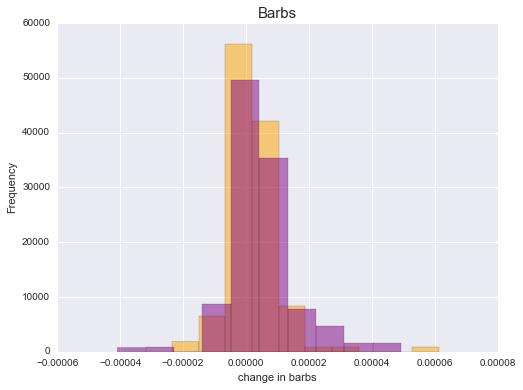

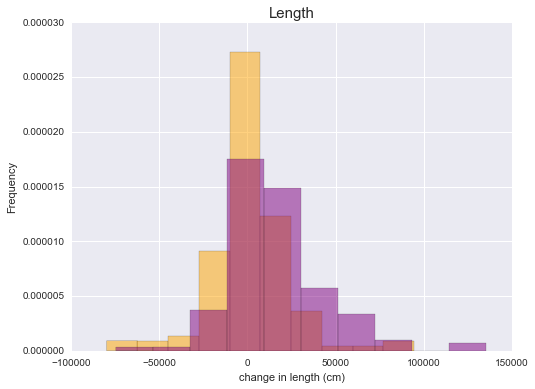

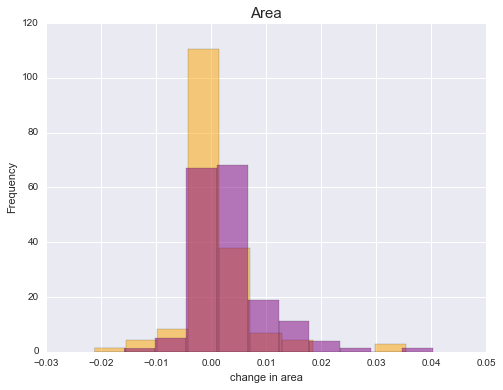

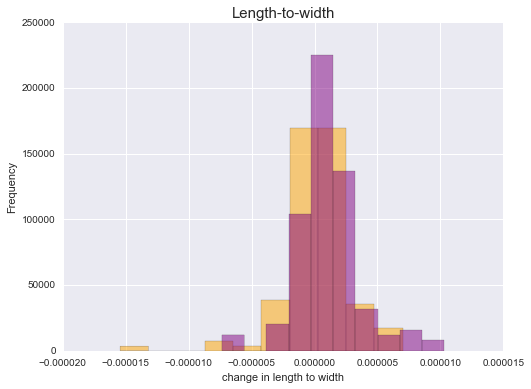

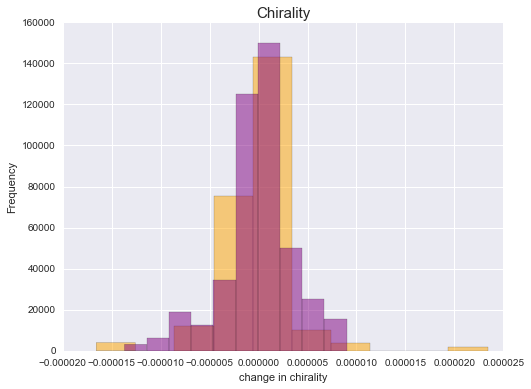

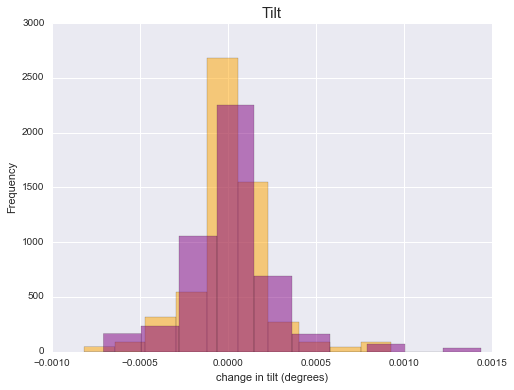

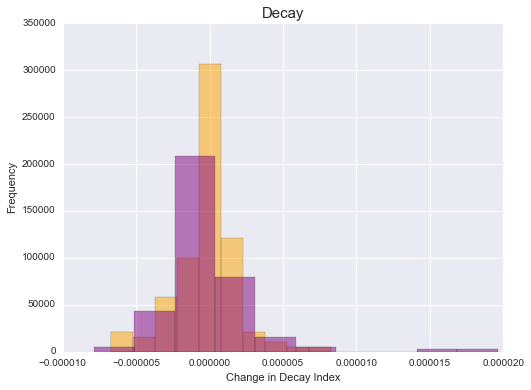

In [134]:
def comparison_plots_slope(parameter, title, xlabel):
    colors=Y
    plt.xlabel(xlabel)
    plt.ylabel('Number of Instances')
    #plt.xlim([-3,3])
    plt.title(title, fontsize=15)
    fig1 = plt.gcf()
    fig1.set_size_inches(7,5.5)
    plt.tight_layout()
    erupting[parameter].plot(kind='hist',rwidth=1.5,  alpha=0.5,color='orange',stacked=True, normed=True)
    non_erupting[parameter].plot(kind='hist',rwidth=1.5, alpha=0.5, color='purple',stacked=True, normed=True)
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/%s_change_hisogram.png'%title)
    plt.show()
    #all_eruptions['avg_barbs'].plot(kind=hist, c=colors)
comparison_plots_slope('barb_slope','Barbs','change in barbs')
comparison_plots_slope('len_slope','Length','change in length (cm)')
comparison_plots_slope('area_slope','Area','change in area')
comparison_plots_slope('L_to_W_slope','Length-to-width','change in length to width')
comparison_plots_slope('chirality_slope','Chirality','change in chirality')
comparison_plots_slope('tilt_slope','Tilt','change in tilt (degrees)')
comparison_plots_slope('decay_index_slope','Decay','Change in Decay Index')

# Taking out the data that doesn't seem to contribute

In [135]:
good_eruptions = all_eruptions.drop(['Track No.', 'avg_barbs', 'avg_area','avg_len','len_stdev','L_to_W_slope','avg_xcen'], 1)

In [136]:

X_2 = good_eruptions.as_matrix()
print X_2

[[ -2.78408256e-01   6.40375785e-01   0.00000000e+00 ...,  -5.50864737e-01
    9.33202223e-01   2.81943027e+01]
 [  2.40084989e+00   2.10505466e-01   1.00000000e+00 ...,  -1.10612171e+00
   -1.03204858e+00   6.74161515e+01]
 [  1.09684559e-01   3.40378714e-01   0.00000000e+00 ...,   3.67831657e-01
    5.25980713e-02   1.34377489e+01]
 ..., 
 [  1.19077595e-01   1.68506917e-01   0.00000000e+00 ...,   3.23204847e-01
   -1.05462605e+00   1.08435120e+01]
 [ -1.76083431e-01   9.64696995e-02   1.00000000e+00 ...,  -4.03902233e-01
    5.71139468e+00   7.88883296e+01]
 [  1.20072252e+00   1.31532719e-01   0.00000000e+00 ...,   4.54366220e-02
    1.50228269e-01   1.11844954e+01]]


# rerunning the random forest classifier

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

#n_trees = [20]*40 #Again, each forest will have 20 trees
n_trees = range(1,41)
scores_limited = []
scores_limited2 = []
scores_limited3 = []
for i in n_trees:
    forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5) #limit the 'depth' of the dicision tree (only split 5 times per tree)
    forest2 = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=2) #compare this with a more limited depth
    forest3 = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=10)
    val_score = cross_val_score(forest, X=X_2, y=Y, cv=10)
    val_score2 = cross_val_score(forest2, X=X_2, y=Y, cv=10)
    val_score3 = cross_val_score(forest3, X=X_2, y=Y, cv=10)
    scores_limited.append(val_score) 
    scores_limited2.append(val_score2)
    scores_limited3.append(val_score3)

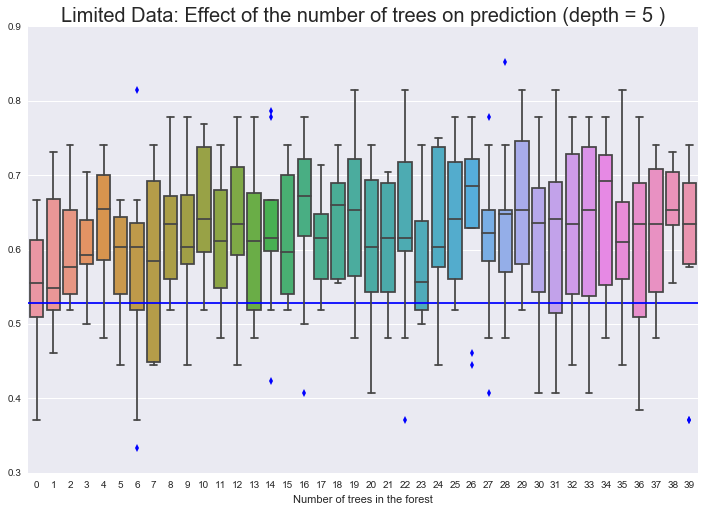

0.61898046398


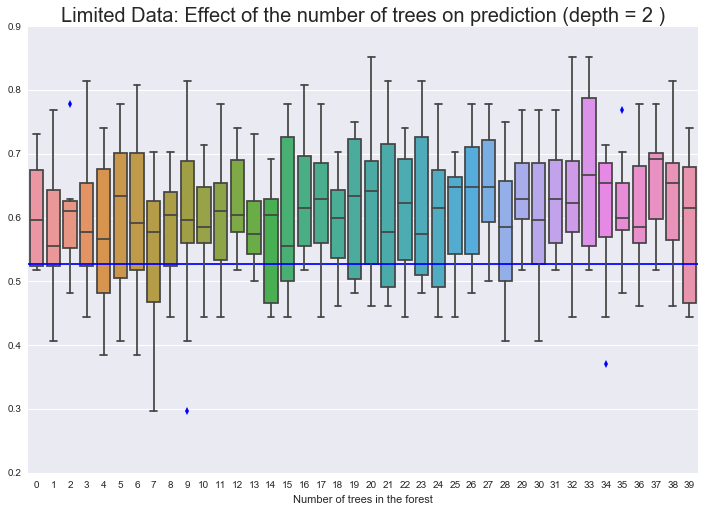

0.608311202686


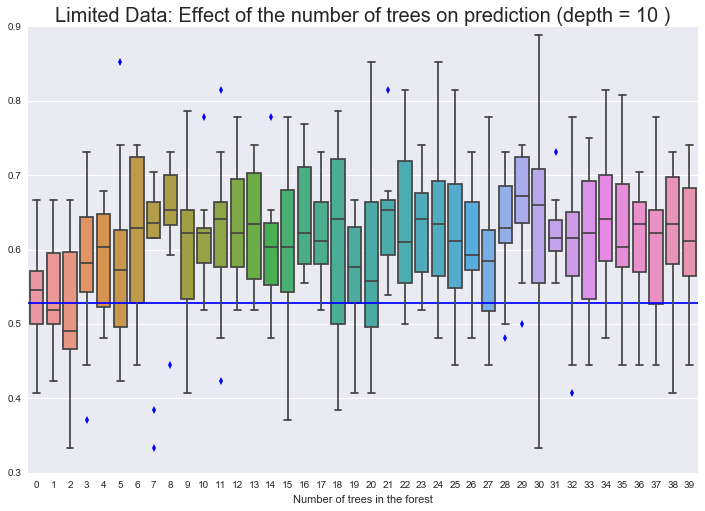

0.609501170126


In [138]:
def plot_scores(scores, depth):
    plt.figure(figsize=(12,8))
    plt.axhline(y=avg)
    plt.title('Limited Data: Effect of the number of trees on prediction (depth = %d )'%depth, fontsize=20)
    plt.xlabel('Number of trees in the forest')
#sns.boxplot(data=scores)
    sns.boxplot(data=scores)
    plt.show()
    print np.mean(scores)
plot_scores(scores_limited, 5)
plot_scores(scores_limited2, 2)
plot_scores(scores_limited3, 10)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/limited_data_1_to_40_trees.png')

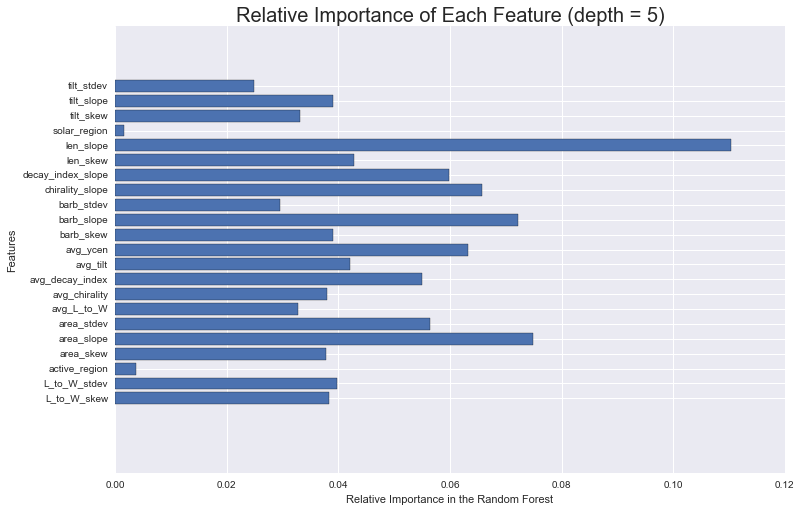

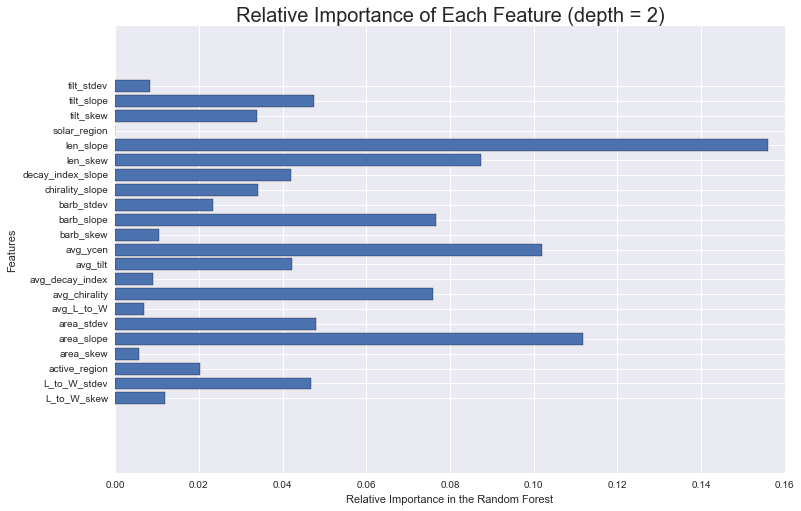

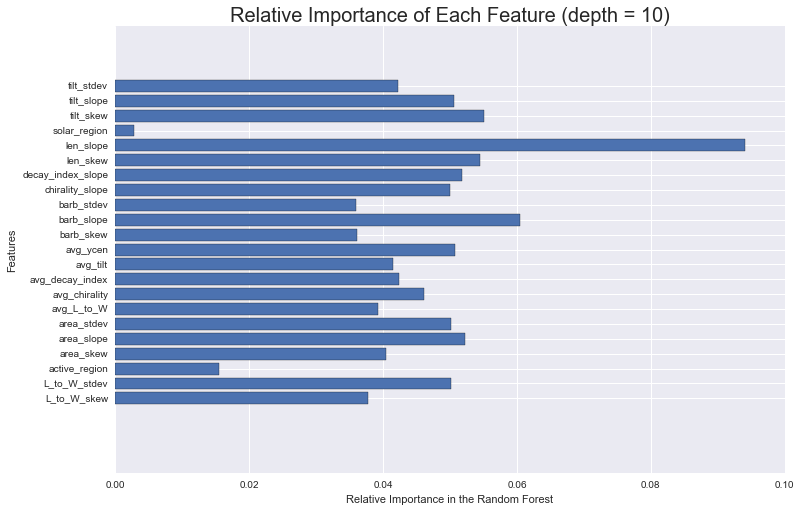

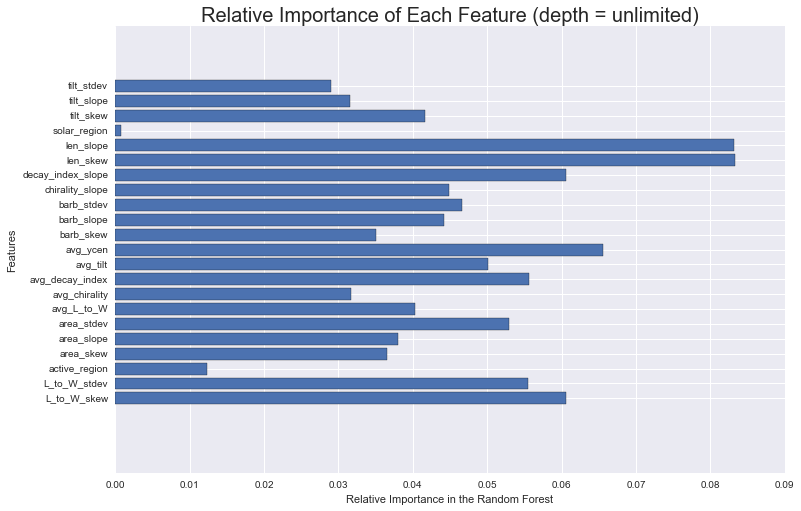

In [139]:
#Which features are most useful for prediction?
#I am using the entire forest from above to find the feature importance.
clf = RandomForestClassifier(n_estimators=15) #Also make a single random forest with 15 trees and test that. 
name_list = good_eruptions.columns
def plot_feature_importance(classifier, name_list, depth):
    #clf = RandomForestClassifier(n_estimators=15)
    #clf.fit(X_2,Y)
    classifier.fit(X_2, Y)
    importance_list = classifier.feature_importances_
    #name_list = good_eruptions.columns
    #importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
    plt.figure(figsize=(12,8))
    plt.barh(range(len(name_list)),importance_list,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.xlabel('Relative Importance in the Random Forest')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature (depth = %s)'%depth,fontsize=20)
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importances_limited.png')
    plt.show()
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importances_limited.png')
plot_feature_importance(forest, name_list, '5')
plot_feature_importance(forest2, name_list,'2')
plot_feature_importance(forest3, name_list,'10')
plot_feature_importance(clf, name_list,'unlimited')

In [140]:
#I am going to try to make the plot Kathy talked about in this cell. So a comparison between F1 and regular
#This is using 40 trees each with 25 trees. 
#Use only good_eruptions (ie without xcen and other lame parameters)
scores_reg = []
scores_f1 = []
n_trees = [25]*40
for i in n_trees:
    forest_2 = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5)
    #Same thing, but using a different type of scoring (f1)
    #The F1 score is defined as the harmonic mean of recall and precision
    #So this tries to balance how well it does at picking out all of the erupting filaments and how many erupting filaments it is correct about
    val_score_r = cross_val_score(forest_2, X=X_2, y=Y, cv=StratifiedKFold(Y,10, shuffle=True))
    val_score_f1 = cross_val_score(forest_2, X=X_2, y=Y, cv=StratifiedKFold(Y,10, shuffle=True), scoring='f1')
    scores_reg.append(val_score_r)
    scores_f1.append(val_score_f1)
    


<function matplotlib.pyplot.show>

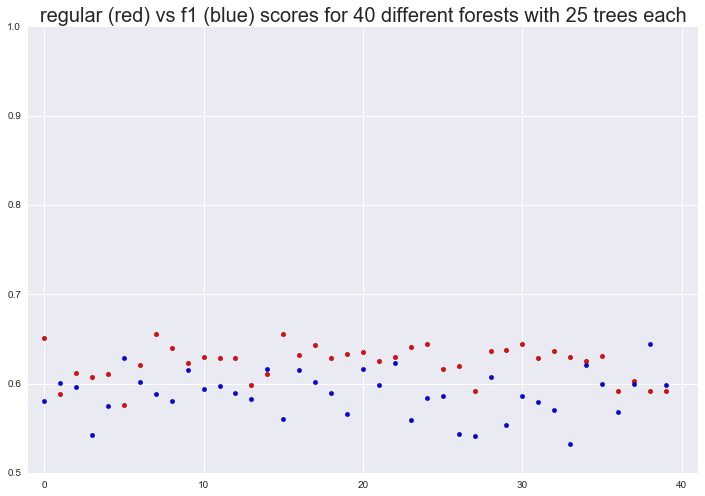

In [141]:
avg_default_score = map(lambda x: np.mean(x), scores_reg)
avg_f1_score = map(lambda x: np.mean(x), scores_f1)
plt.figure(figsize=(12,8))
plt.title('regular (red) vs f1 (blue) scores for 40 different forests with 25 trees each',fontsize=20)
plt.xlim(-1,41)
plt.ylim(0.5, 1.0)
plt.scatter(range(len(avg_default_score)), avg_default_score, c='r')
plt.scatter(range(len(avg_f1_score)), avg_f1_score)
plt.show
#sns.boxplot(scores_2)
#plt.axhline(y=1-avg)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/f1_scoring_25_trees.png')

In [69]:
#OK, now I want to try to visualize a single decision tree and break down the splits that are made
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import subprocess

single_tree = DecisionTreeClassifier(max_depth=5)
single_tree.fit(X_2, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [70]:
# taken from http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("test_tree.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "test_tree.dot", "-o", "test_tree.png"]
    try:
        #os.popen(command)
        #You will need to install graphviz in order to do this. 
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [71]:
feature_names = good_eruptions.columns.values

In [72]:
visualize_tree(single_tree, feature_names)

# Different ways to get Cumulative distribution functions for various paramters

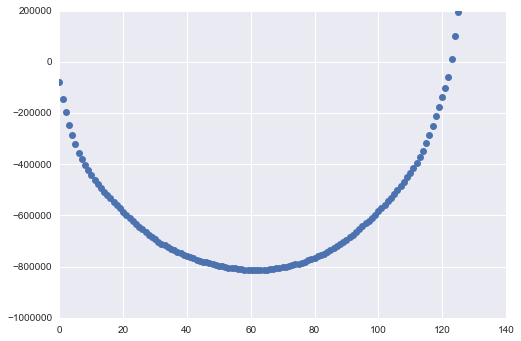

In [73]:
erupt_slen_data = erupting['len_slope']
sorted_erupt_slen = np.sort(erupt_slen_data)
cumulative = np.cumsum(sorted_erupt_slen)

plt.plot(cumulative, 'o')
plt.show()


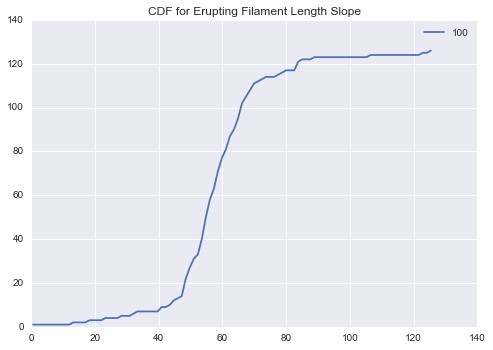

In [74]:
from __future__ import division
import numpy as np
from scipy.stats import cumfreq
import pylab as plt
erupt_slen_data = erupting['len_slope']
sorted_erupt_slen = np.sort(erupt_slen_data)
#cumulative = np.cumsum(sorted_erupt_slen)

#plt.plot(cumulative, 'o')
#plt.show()

hi = len(erupt_slen_data)
a = sorted_erupt_slen
for nbins in (2, 20, 100):
    cf = cumfreq(a, nbins)  # bin values, lowerlimit, binsize, extrapoints
    w = hi / nbins
    x = np.linspace( w/2, hi - w/2, nbins )  # care
    # print x, cf
plt.plot( x, cf[0], label=str(nbins) )
plt.title('CDF for Erupting Filament Length Slope')
plt.legend()
plt.show()

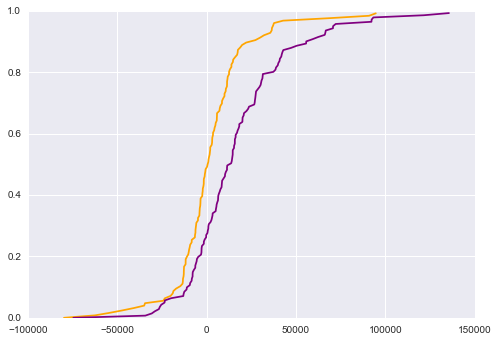

In [75]:
sorted=np.sort(erupting['len_slope'].tolist())
yvals=np.arange(len(sorted))/float(len(sorted))
plt.plot( sorted, yvals,color='orange' )

sorted=np.sort(non_erupting['len_slope'].tolist())
yvals=np.arange(len(sorted))/float(len(sorted))
plt.plot( sorted, yvals,color='purple' )

In [76]:
def cumulativedistribution(eruptingdata, noneruptingdata):
    sorted=np.sort(eruptingdata.tolist())
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals,color='orange' )

    sorted=np.sort(noneruptingdata.tolist())
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals,color='purple' )
    plt.title('Cumulative Distribution Functions y cen')

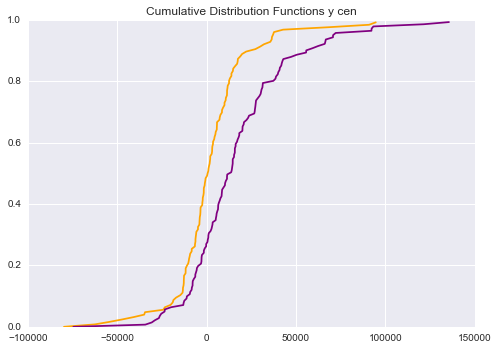

In [77]:
cumulativedistribution(erupting['len_slope'], non_erupting['len_slope'])

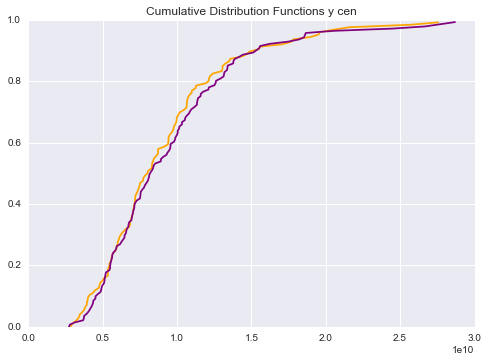

In [78]:
cumulativedistribution(erupting['avg_len'], non_erupting['avg_len'])

Track No.
Track No.
avg_len
avg_len
len_slope
len_slope
len_stdev
len_stdev
len_skew
len_skew
avg_area
avg_area
area_slope
area_slope
avg_chirality
avg_chirality
avg_decay_index
avg_decay_index
decay_index_slope
decay_index_slope
area_stdev
area_stdev
area_skew
area_skew
chirality_slope
chirality_slope
avg_barbs
avg_barbs
barb_slope
barb_slope
barb_stdev
barb_stdev
barb_skew
barb_skew
avg_tilt
avg_tilt
tilt_slope
tilt_slope
tilt_stdev
tilt_stdev
tilt_skew
tilt_skew
avg_xcen
avg_xcen
avg_ycen
avg_ycen
avg_L_to_W
avg_L_to_W
L_to_W_slope
L_to_W_slope
L_to_W_stdev
L_to_W_stdev
L_to_W_skew
L_to_W_skew
solar_region
solar_region
Eruption
Eruption

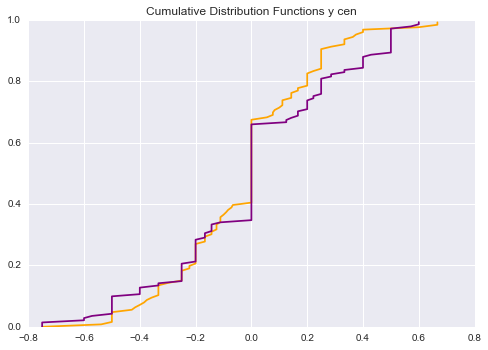

In [79]:
cumulativedistribution(erupting['avg_chirality'], non_erupting['avg_chirality'])

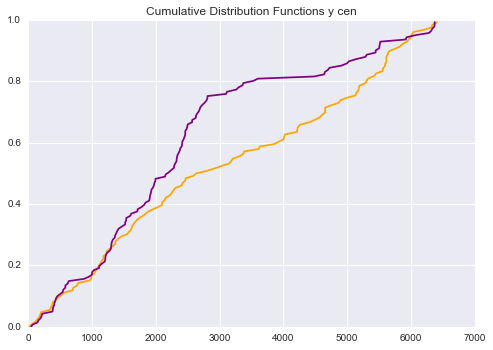

In [80]:
cumulativedistribution(erupting['Track No.'], non_erupting['Track No.'])

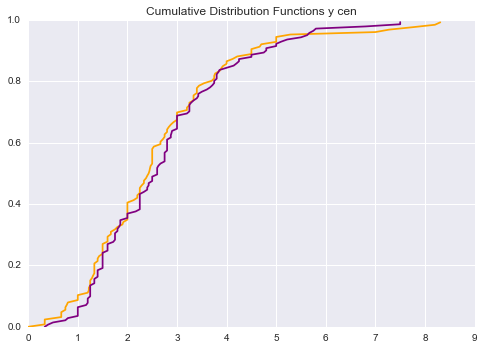

In [81]:
cumulativedistribution(erupting['avg_barbs'], non_erupting['avg_barbs'])

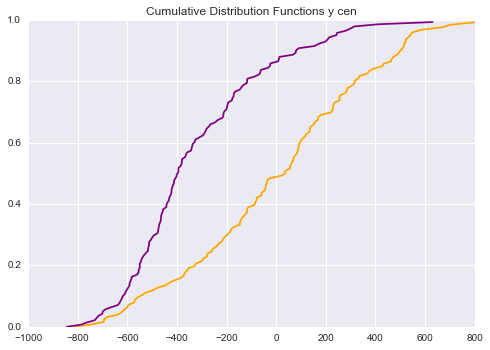

In [82]:
cumulativedistribution(erupting['avg_xcen'], non_erupting['avg_xcen'])

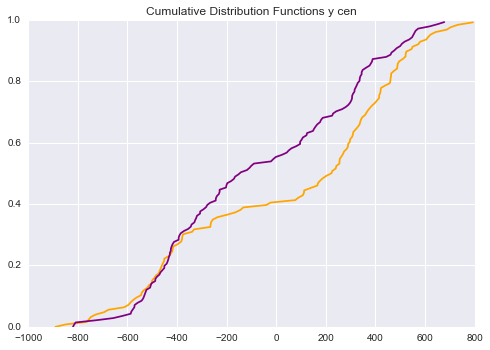

In [83]:
cumulativedistribution(erupting['avg_ycen'], non_erupting['avg_ycen'])

In [84]:
X_2?

In [87]:
#OK, doing a confusion matrix is a bit different
#Above, we used cross_val_score, which automatically splits things up in training and test sets
#We will have to manually do that here
#There is probably a way to do it, but I don't know what it is at the moment

from sklearn.cross_validation import train_test_split

#train, test = train_test_split(, test_size = 0.2)

# Create the random forest object which will include all the parameters
# for the fit, this forest has 25 trees with a max depth of 5
confusion_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25, max_depth=5) 

# Fit the training data to the Survived labels and create the decision trees

X_train,X_test,y_train,y_test = train_test_split(X_2,Y,test_size=0.4)
confusion_forest = confusion_forest.fit(X_train,y_train)

# Take the same decision trees and run it on the test data
y_pred = confusion_forest.predict(X_test)

In [88]:
sklearn.metrics.confusion_matrix(y_test, y_pred, labels=None)

array([[45, 10],
       [27, 25]])